# Which bear is it?

This article has as it's goal creating an artificial intelligence capable of identifying Monark and bicycles

with that in mind, the necessary libraries were installed:

In [1]:
    !pip install spacy --upgrade
    !pip install -Uqq fastai duckduckgo_search

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 34.8 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: spacy
    Found existing installation: spacy 3.6.0
    Uninstalling spacy-3.6.0:
      Successfully uninstalled spacy-3.6.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ypy-websocket 0.8.2 requires aiofiles<23,>=22.1.0, but you have aiofiles 23.2.1 which is incompatible.


So it is possible to look for images  in the internet, the function search_images was creted in the following cell.

In [2]:
from duckduckgo_search import ddg_images
from fastcore.all import *

def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

Now, this function is used and, the URLs returned by it are used by another function, download_url, to download the image files:

In [3]:
from fastdownload import download_url
from fastai.vision.all import *
lista = ['monark_podcaster.jpg','bicicleta.jpg']
for o in lista:
    photo = search_images(o,max_images=1)
    download_url(photo[0], o, show_progress=True)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Searching for 'monark_podcaster.jpg'


/opt/conda/lib/python3.10/site-packages/duckduckgo_search/compat.py:60: UserWarning: ddg_images is deprecated. Use DDGS().images() generator
  warnings.warn("ddg_images is deprecated. Use DDGS().images() generator")
/opt/conda/lib/python3.10/site-packages/duckduckgo_search/compat.py:64: UserWarning: parameter page is deprecated
  warnings.warn("parameter page is deprecated")
/opt/conda/lib/python3.10/site-packages/duckduckgo_search/compat.py:66: UserWarning: parameter max_results is deprecated
  warnings.warn("parameter max_results is deprecated")


Searching for 'bicicleta.jpg'


the files were all stored in the root folder:

In [4]:
!ls

bicicleta.jpg  monark_podcaster.jpg


Fast.ai can work with images in the root folder via the .open method, see below.
 the to_thumb method was used so we can actually see the pictures:

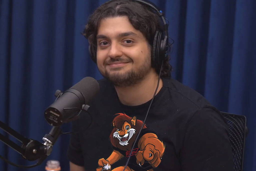

In [5]:
im1 = Image.open(lista[0])
im1.to_thumb(256,256)

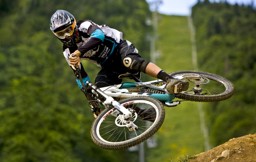

In [6]:
im2 = Image.open(lista[1])
im2.to_thumb(256,256)

In order to classify the previously downloaded images an dataset is required to train the AI model, so the  function  search_images was used again in conjuction with the download_images function:

In [7]:
searches = ['monark_podcaster','bicicleta']
path = Path('Bicicleta_ou_Monark')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(1)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{o} ar livre'))
    sleep(1)
    download_images(dest, urls=search_images(f'{o} entrevista'))
    sleep(1)
    resize_images(path/o, max_size=400, dest=path/o)

Searching for 'monark_podcaster photo'
Searching for 'monark_podcaster ar livre'
Searching for 'monark_podcaster entrevista'
Searching for 'bicicleta photo'
Searching for 'bicicleta ar livre'
Searching for 'bicicleta entrevista'


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [8]:


failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)



3

the cell above removes pictures that were incorrectly downloaded.

In [9]:
!ls

Bicicleta_ou_Monark  bicicleta.jpg  monark_podcaster.jpg


the cell below organize the images downloaded in  a Data block that will later be used to train the AI, here is what which parameter means:

ImageBlock: The dataset is made of Images.
category block: The images will be classified in categories
get_items=get_image_files : gets the image files so they are used as data.
splitter=RandomSplitter(valid_pct=0.2, seed=42): separates 20% of the data for the validation set, the rest is training set.
get_y=parent_label: the labels are the name of the parent folder where the pictures are.

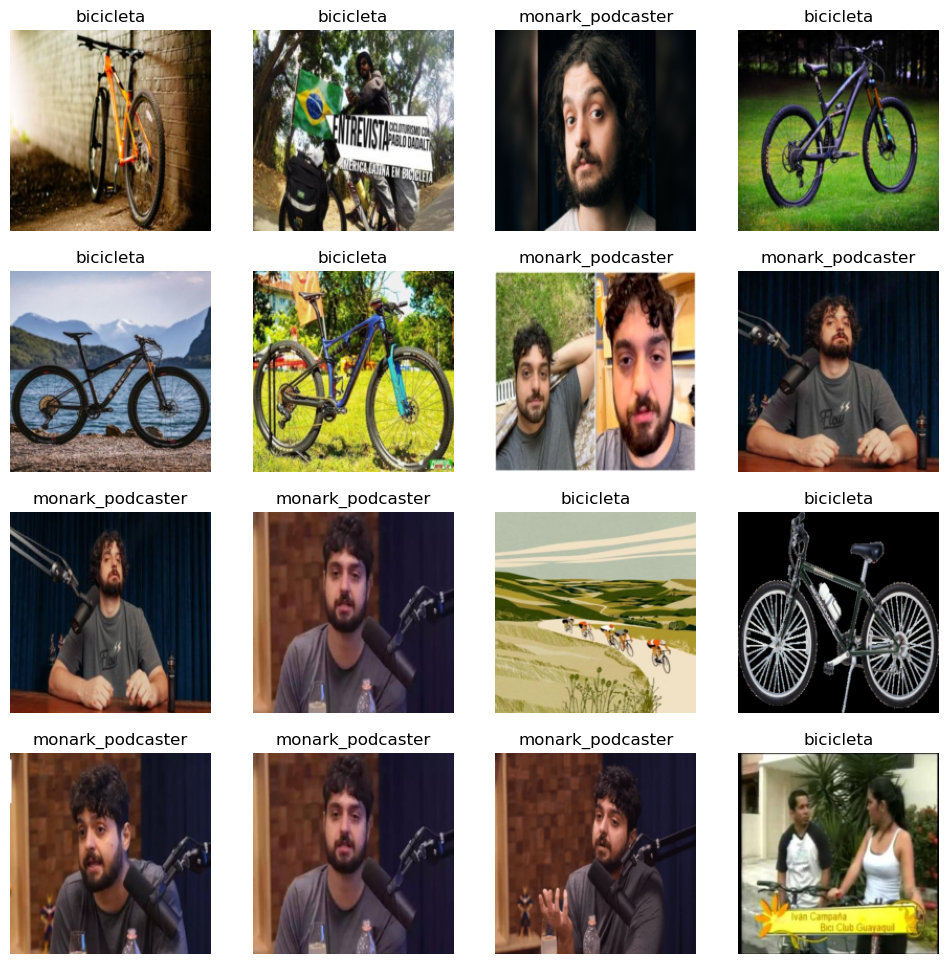

In [10]:


dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=16)



the cell below trains the model.

In [11]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 180MB/s] 


epoch,train_loss,valid_loss,error_rate,time
0,0.856154,0.892209,0.212121,00:09


epoch,train_loss,valid_loss,error_rate,time
0,0.380985,0.367945,0.121212,00:14
1,0.258110,0.324501,0.090909,00:13
2,0.175878,0.335316,0.060606,00:13


In order to fix possible mistakes with the dataset, the confusion matrix was used:


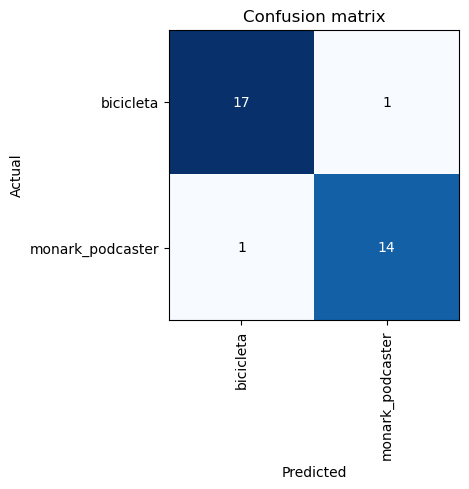

In [12]:

interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In order to fix possible issues with the dataset, the top loses were plotted and then the dataset was manually cleaned:

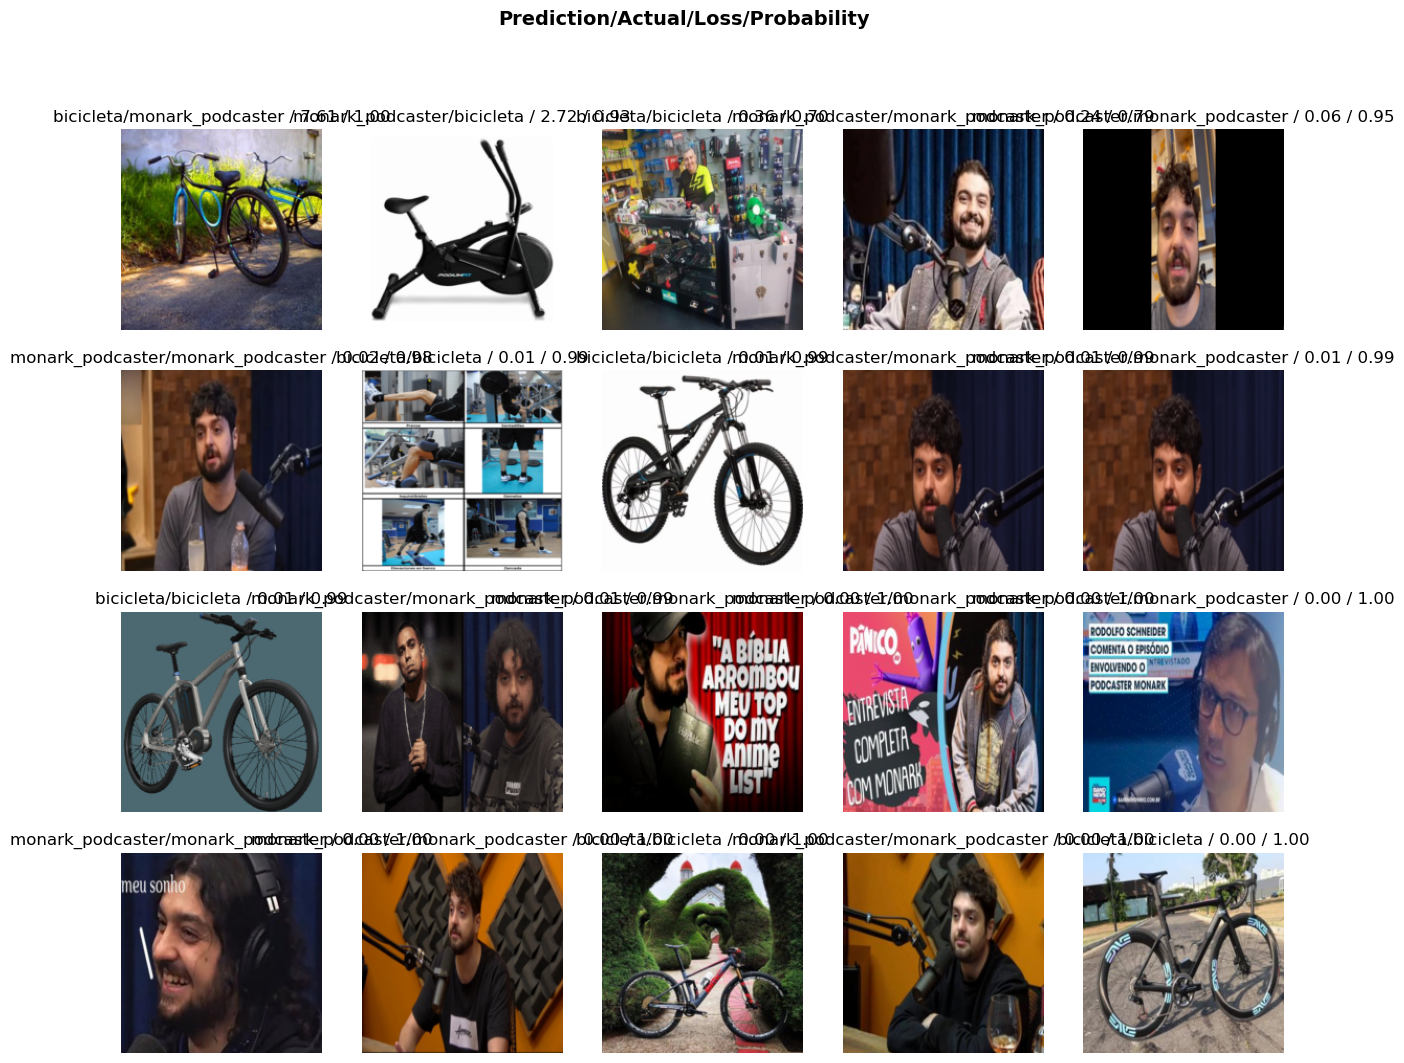

In [13]:
interp.plot_top_losses(20, nrows=4)

In [14]:
from fastai.vision.widgets import *
cleaner = ImageClassifierCleaner(learn)
cleaner

In [15]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()

the cell below simply trains the model again, with the manually fixed dataset:

In [17]:

dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

epoch,train_loss,valid_loss,error_rate,time
0,1.053036,0.038998,0.000000,00:14


epoch,train_loss,valid_loss,error_rate,time
0,0.331508,0.068644,0.030303,00:21
1,0.198532,0.144805,0.030303,00:21
2,0.146487,0.091207,0.030303,00:21


now the model is tested and exported:

This is a: monark_podcaster.
Probability it's monark: 0.9975


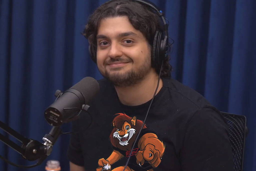

In [28]:
what_is_it,_,probs = learn.predict(PILImage.create(lista[0]))
print(f"This is a: {what_is_it}.")
print(f"Probability it's monark: {probs[1]:.4f}")
im1.to_thumb(256,256)

This is a: bicicleta.
Probability bicicleta: 0.9918


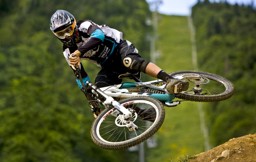

In [29]:
what_is_it,_,probs = learn.predict(PILImage.create(lista[1]))
print(f"This is a: {what_is_it}.")
print(f"Probability bicicleta: {probs[0]:.4f}")
im2.to_thumb(256,256)

In [30]:


learn.export()
     
